In [16]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [17]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.datetime.now()])
    return xda

data = xr.open_mfdataset('/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/obbudelm-F21/decile_bins/era5_Maize_tasmax_growing_season_deciles_*.nc', preprocess = add_time_dim)

data['time'] = np.arange(1981,2019+1)

data.load()

<xarray.Dataset>
Dimensions:              (bin: 11, lat: 721, lon: 1440, time: 39)
Coordinates:
  * time                 (time) int64 1981 1982 1983 1984 ... 2017 2018 2019
  * bin                  (bin) int64 0 10 20 30 40 50 60 70 80 90 100
  * lat                  (lat) float32 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * lon                  (lon) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    tasmax_grow_deciles  (time, lat, lon, bin) float64 nan nan ... -28.22 -16.63

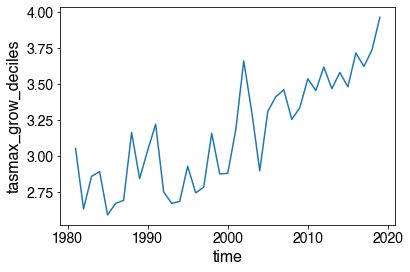

In [37]:
data.tasmax_grow_deciles.mean(dim=['lat', 'lon', 'bin']).plot()

In [3]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

# dirEra5 = '/dartfs-hpc/rc/lab/C/CMIG/ERA5'

years = [1979, 2019]



In [4]:

ds_grow_r_t_et = xr.open_dataset('r_t_et_era5.nc')
ds_grow_r_t_et.load()


<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    r_t_et   (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

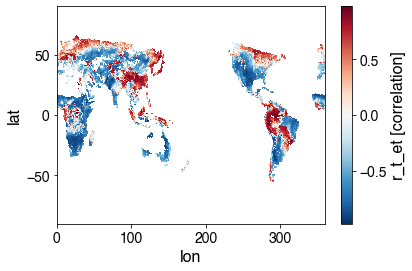

In [5]:
ds_grow_r_t_et.r_t_et.plot()

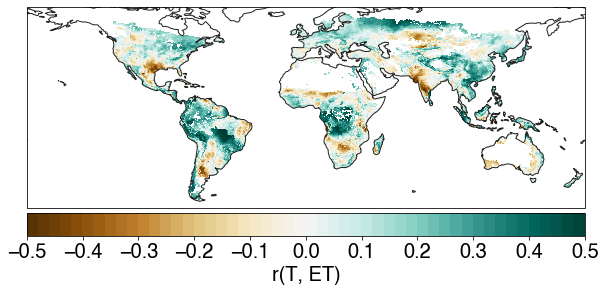

In [16]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 70, -60])

v1 = -.5
v2 = .51
vstep = .02
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = ds_grow_r_t_et.r_t_et.values

c = plt.pcolormesh(ds_grow_r_t_et.lon, ds_grow_r_t_et.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(T, ET)', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)

In [4]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dirAgData)
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [5]:
# calc era5 quantiles
ds_tasmax = xr.open_mfdataset('%s/monthly/tasmax_*.nc'%(dirEra5))
ds_tasmax.load()
ds_tasmax['mx2t'] -= 273.15

ds_evap = xr.open_mfdataset('%s/monthly/evapotranspiration_monthly_*.nc'%(dirEra5Land))
ds_evap.load()
ds_evap['e'] *= -1

ds_tasmax = ds_tasmax.sel(time=slice('1981','2018'))
ds_evap = ds_evap.sel(time=slice('1981','2018'))

# ds_tp = xr.open_mfdataset('%s/monthly/tp_*.nc'%dirEra5)
# ds_tp.load()
# ds_quantile = ds.chunk({'latitude':500, 'longitude':500, 'time': -1}).quantile(q=[.01, .05, .1, .9, .95, .99], dim='time')
# ds_quantile.tw.to_netcdf('era5_tw_mean_quantiles.nc')

In [6]:
ds_evap = ds_evap.rename_dims(latitude='lat', longitude='lon')
ds_evap = ds_evap.rename({'latitude':'lat', 'longitude':'lon'})

In [7]:
lat = ds_tasmax.latitude.values
lon = ds_tasmax.longitude.values

# regrid sacks data
regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_start = xe.Regridder(xr.DataArray(data=sacksStart, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)
regridder_end = xe.Regridder(xr.DataArray(data=sacksEnd, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)

sacksStart_regrid = regridder_start(sacksStart)
sacksEnd_regrid = regridder_end(sacksEnd)

regridder_e_era5land = xe.Regridder(xr.DataArray(data=ds_evap.e, dims=['time', 'lat', 'lon'], coords={'time': ds_evap.time, 'lat':ds_evap.lat, 'lon':ds_evap.lon}), regridMesh, 'bilinear', reuse_weights=True)
ds_evap_regrid = regridder_e_era5land(ds_evap)


Reuse existing file: bilinear_360x720_721x1440.nc
Reuse existing file: bilinear_360x720_721x1440.nc
Reuse existing file: bilinear_1801x3600_721x1440.nc
using dimensions ('lat', 'lon') from data variable e as the horizontal dimensions for this dataset.


In [8]:
sacksStart_regrid[sacksStart_regrid<1]=1
sacksEnd_regrid[sacksEnd_regrid<1]=1

In [9]:
def is_growing_season(month, sacks_start, sacks_end):
    if sacks_start < sacks_end:
        return (month >= sacks_start) & (month <= sacks_end)
    else:
        return (month >= sacks_start) | (month <= sacks_end)

In [10]:
with open('%s/cropped_area/crop_land_regrid_era5.dat'%(dirAg6), 'rb') as f:
    crop_ha_regrid = pickle.load(f)

In [11]:
nnLen = lat.size*lat.size

In [12]:

n = 0

r_t_et = np.full([len(lat), len(lon)], np.nan)

for xlat in range(len(lat)):

    for ylon in range(len(lon)):

        if n % 50000 == 0:
                print('%.1f %% complete'%(n/(nnLen)*100))
                
        if ~np.isnan(sacksStart_regrid[xlat, ylon]) and ~np.isnan(sacksEnd_regrid[xlat, ylon]) and crop_ha_regrid[xlat, ylon] > 0:

            
            
            sacks_start_month = datetime.datetime.strptime('2020%d'%int(sacksStart_regrid[xlat,ylon]), '%Y%j').date().month
            sacks_end_month = datetime.datetime.strptime('2020%d'%int(sacksEnd_regrid[xlat,ylon]), '%Y%j').date().month
            
            # select growing seasons for all years
            ds_tasmax_growing = ds_tasmax.mx2t[:,xlat,ylon].sel(time=is_growing_season(ds_tasmax['time.month'], sacks_start_month, sacks_end_month))
            ds_evap_growing = ds_evap_regrid.e[:,xlat,ylon].sel(time=is_growing_season(ds_tasmax['time.month'], sacks_start_month, sacks_end_month))
            

            # resample to group growing seasons (1 year frequency, offset starting at 1 month before start of growing season)
            ds_tasmax_growing_1y = ds_tasmax_growing.resample(time='1Y', loffset='%dM'%(sacks_start_month-1)).mean()
            ds_evap_growing_1y = ds_evap_growing.resample(time='1Y', loffset='%dM'%(sacks_start_month-1)).mean()
            
            r_t_et[xlat, ylon] = np.corrcoef(ds_tasmax_growing_1y.values,ds_evap_growing_1y.values)[0,1]

        n += 1
                


0.0 % complete
9.6 % complete
19.2 % complete
28.9 % complete
38.5 % complete
48.1 % complete


KeyboardInterrupt: 

In [46]:
da_grow_r_t_et = xr.DataArray(data   = r_t_et, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':lat, 'lon':lon},
                      attrs  = {'units'     : 'correlation'
                        })
ds_grow_r_t_et = xr.Dataset()
ds_grow_r_t_et['r_t_et'] = da_grow_r_t_et


print('saving netcdf...')
ds_grow_r_t_et.to_netcdf('r_t_et_era5.nc')


saving netcdf...


In [47]:
ds_grow_r_t_et.r_t_et.p

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    r_t_et   (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan